# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.


In [4]:
!pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html --upgrade

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/rocm5.2/torch-1.13.1%2Brocm5.2-cp37-cp37m-linux_x86_64.whl (1342.9 MB)
  Using cached https://download.pytorch.org/whl/rocm5.2/torchvision-0.14.1%2Brocm5.2-cp37-cp37m-linux_x86_64.whl (70.8 MB)


In [5]:
!pip install jinja2==3.0.2

  Using cached Jinja2-3.0.2-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
spyder 4.0.1 requires jedi==0.14.1, but you have jedi 0.18.2 which is incompatible.


In [6]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os 
import gzip
import boto3
import random
import IPython
import numpy as np

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

from torchvision import transforms
from torchvision.datasets import CIFAR10

[2023-06-27 12:04:57.527 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [7]:
session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-691577916223
AWS Region: us-east-1
RoleArn: arn:aws:iam::691577916223:role/service-role/AmazonSageMaker-ExecutionRole-20230128T162274


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [8]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-06-26 15:26:53--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.220.200
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.220.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  34.2MB/s    in 39s     

2023-06-26 15:27:36 (28.0 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
inputs = session.upload_data(path="dogImages", bucket=bucket)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-691577916223/data


In [13]:
inputs = 's3://sagemaker-us-east-1-691577916223/data'

In [10]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [11]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=5,
    max_parallel_jobs=5,
    objective_type=objective_type,
)

In [12]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [13]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-06-26 17:25:54 Starting - Preparing the instances for training
2023-06-26 17:25:54 Downloading - Downloading input data
2023-06-26 17:25:54 Training - Training image download completed. Training in progress.
2023-06-26 17:25:54 Uploading - Uploading generated training model
2023-06-26 17:25:54 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"512"',
 'epochs': '3',
 'learning_rate': '0.008962410227091062',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-06-26-16-52-16-728"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-691577916223/pytorch-training-2023-06-26-16-52-16-728/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [21]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [22]:
hyperparameters= {
    "learning_rate": 0.008962410227091062,
    "batch_size": 512,
    "epochs": 3
}


estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c4.2xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

In [23]:
estimator.fit({"training": inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


Using provided s3_resource


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-06-27-12-44-42-903


2023-06-27 12:44:43 Starting - Starting the training job...
2023-06-27 12:45:11 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-06-27 12:46:11 Downloading - Downloading input data......
2023-06-27 12:47:12 Training - Downloading the training image...
2023-06-27 12:47:37 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-27 12:47:29,125 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-27 12:47:29,128 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-27 12:47:29,137 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-

In [24]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-06-27-12-44-42-903
Region: us-east-1


[2023-06-27 13:02:53.407 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-691577916223/pytorch-training-2023-06-27-12-44-42-903/debug-output/
[2023-06-27 13:02:54.025 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-06-27 13:02:55.043 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


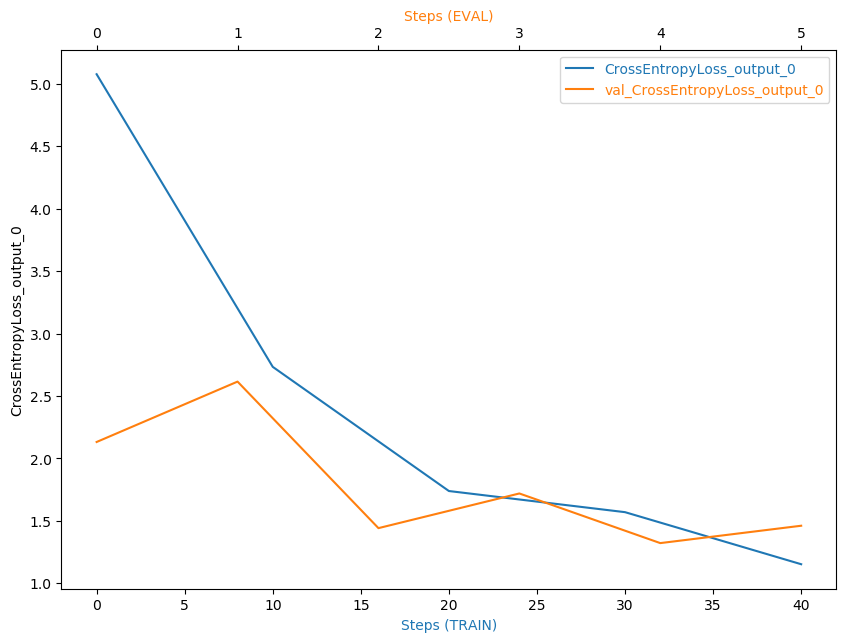

In [25]:
# TODO: Plot a debugging output
import matplotlib.pyplot as plt
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

# Ploting
trial = create_trial(f's3://{bucket}/{training_job_name}/debug-output/')
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [26]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

You will find the profiler report in s3://sagemaker-us-east-1-691577916223/pytorch-training-2023-06-27-12-44-42-903/rule-output
2023-06-27 13:02:00     364549 pytorch-training-2023-06-27-12-44-42-903/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-06-27 13:02:00     211606 pytorch-training-2023-06-27-12-44-42-903/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-06-27 13:01:55        192 pytorch-training-2023-06-27-12-44-42-903/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-06-27 13:01:55        200 pytorch-training-2023-06-27-12-44-42-903/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-06-27 13:01:55       1865 pytorch-training-2023-06-27-12-44-42-903/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-06-27 13:01:55        127 pytorch-training-2023-06-27-12-44-42-903/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [32]:
IPython.display.HTML(filename="ProfilerReport/profiler-output/profiler-report.html")

## Model Deploying

In [27]:
import sagemaker
from sagemaker.pytorch import PyTorchModel

from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# loading estimator from s3
# training_job_name = 'pytorch-training-2023-06-27-12-44-42-903'
# estimator = sagemaker.estimator.Estimator.attach(training_job_name)
model_location=estimator.model_data

# TODO: Deploy your model to an endpoint
model = PyTorchModel(
    entry_point="inference.py",
    role=role,
    model_data=f's3://{bucket}/{training_job_name}/output/model.tar.gz',
    framework_version="1.5.0",
    py_version="py3",
)

In [28]:
# SageMaker instance
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.c4.xlarge",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-691577916223/pytorch-training-2023-06-27-12-44-42-903/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-691577916223/pytorch-inference-2023-06-27-13-03-35-762/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-06-27-13-03-39-943
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-06-27-13-03-40-889
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-06-27-13-03-40-889


------!

In [29]:
import torchvision
import torchvision.transforms as transforms
from PIL import Image

img_path = "dogImages/test/056.Dachshund/Dachshund_04003.jpg"

image = Image.open(img_path)

testing_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_tensor = testing_transform(image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor_pred = np.array(img_tensor)

In [30]:
# TODO: Run an prediction on the endpoint
response = predictor.predict({"inputs": img_tensor_pred})
response

[[-3.177473783493042,
  -1.1588046550750732,
  -1.59476637840271,
  -1.1653517484664917,
  -3.6101527214050293,
  -2.7936582565307617,
  -2.802391529083252,
  -1.6524158716201782,
  -4.2331132888793945,
  -2.214852809906006,
  -0.6907296180725098,
  -2.2108709812164307,
  -1.372286319732666,
  -3.1459832191467285,
  -2.953416109085083,
  -0.6686264276504517,
  -4.977683067321777,
  -4.378859043121338,
  -3.4448843002319336,
  -2.0580127239227295,
  -6.2872538566589355,
  -3.7812001705169678,
  -2.4579057693481445,
  -6.302458763122559,
  -7.78315544128418,
  -2.0565309524536133,
  -3.234053134918213,
  -4.618637561798096,
  -4.22952938079834,
  -0.11594423651695251,
  -1.27395761013031,
  -2.068920612335205,
  -5.398288249969482,
  -1.1745790243148804,
  -2.7261295318603516,
  -2.154534101486206,
  -2.0236599445343018,
  -0.2921046018600464,
  -3.010840892791748,
  -2.0796098709106445,
  -4.614152908325195,
  -3.754784345626831,
  -1.2861300706863403,
  -0.9258508682250977,
  -3.530961

In [31]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-06-27-13-03-40-889
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-06-27-13-03-40-889
